<a href="https://colab.research.google.com/github/jktluna/WasteReduxImageClassification/blob/main/ImageClassification1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflowjs

INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 48.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 48.1 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully unin

In [2]:
!pip install tensorflow-model-optimization

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 4.8 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.layers import InputLayer
from tensorflow.keras import layers

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
folder_path = '/content/drive/MyDrive/path/ColabNotebooks'

In [6]:
data_train_path = '/content/drive/MyDrive/ColabNotebooks/basedata/train'
data_val_path = '/content/drive/MyDrive/ColabNotebooks/basedata/validation'
data_test_path = '/content/drive/MyDrive/ColabNotebooks/basedata/test'

In [7]:
img_width = 180
img_height = 180

In [8]:
import os
print(os.listdir('/content/drive/MyDrive/ColabNotebooks/basedata'))
print(os.listdir('/content/drive/MyDrive/ColabNotebooks/basedata/test'))


['test', 'train', 'validation']
['unrecognized', 'metal', 'plastic', 'glass']


In [9]:
data_train = tf.keras.utils.image_dataset_from_directory(
    data_train_path,
    shuffle = True,
    image_size = (img_width, img_height),
    batch_size = 32,
    validation_split = False)


Found 5155 files belonging to 4 classes.


In [10]:
data_cat = data_train.class_names

In [11]:
data_val = tf.keras.utils.image_dataset_from_directory(data_val_path,
                                                      image_size=(img_height, img_width),
                                                      batch_size=32,
                                                      shuffle=False,
                                                      validation_split=False)


Found 5155 files belonging to 4 classes.


In [12]:
data_test = tf.keras.utils.image_dataset_from_directory(data_test_path,
                                                      image_size=(img_height, img_width),
                                                      batch_size=32,
                                                      shuffle=False,
                                                      validation_split=False)

Found 5155 files belonging to 4 classes.


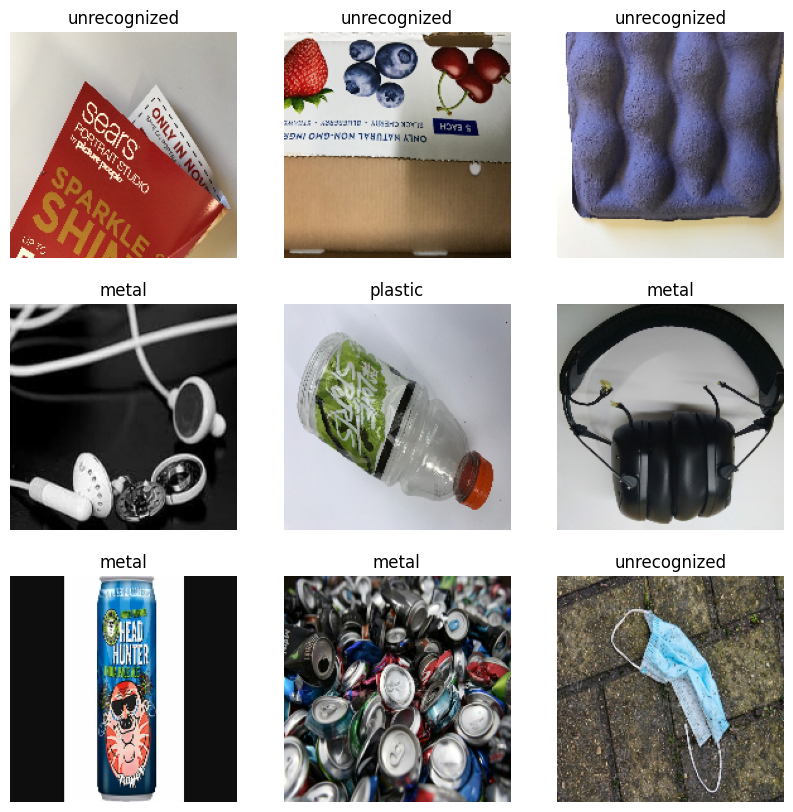

In [13]:
plt.figure(figsize=(10,10))
for image, labels in data_train.take(1):
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(image[i].numpy().astype('uint8'))
        plt.title(data_cat[labels[i]])
        plt.axis('off')
plt.show()

**training the model**

In [14]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (InputLayer, GlobalAveragePooling2D, Dropout, Dense, BatchNormalization)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from tensorflow.keras.optimizers import Adam

In [15]:
# I PERSONALLY ADD THIS DATA AUGMENTATION
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomContrast, RandomBrightness
data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.2),
    RandomZoom(0.1),
    RandomContrast(0.1),
    RandomBrightness(0.1),
])

In [16]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
# base_model.trainable = True
fine_tune_at = 50  # Unfreeze layers after 50
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [17]:
model = Sequential([
    InputLayer(shape=(img_height, img_width, 3)),
    data_augmentation,
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(128, activation='relu', kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(len(data_cat), activation='softmax')
])

In [18]:
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [19]:
epochs_size = 30
history = model.fit(
    data_train,
    validation_data=data_val,
    epochs=epochs_size,
)

Epoch 1/30
  9/162 ━━━━━━━━━━━━━━━━━━━━ 43:42 17s/step - accuracy: 0.4746 - loss: 1.6533

InvalidArgumentError: Graph execution error:

Detected at node decode_image/DecodeImage defined at (most recent call last):
<stack traces unavailable>
Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]
	 [[IteratorGetNext]] [Op:__inference_one_step_on_iterator_36832]

**evaluating the model**

In [ ]:
epochs_range = range(len(history.history['accuracy']))
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs_range, history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend(loc='lower right')

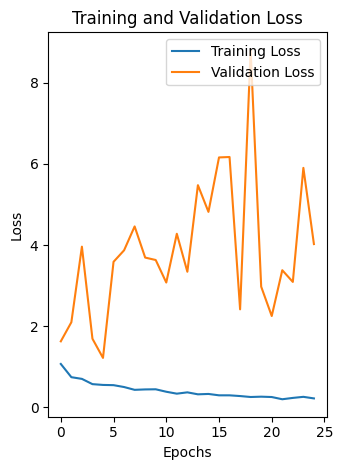

In [ ]:
# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history.history['loss'], label='Training Loss')
plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend(loc='upper right')
plt.show()

In [ ]:
image = 'c.jpg'
image = tf.keras.utils.load_img(image, target_size=(img_height,img_width))
img_arr = tf.keras.utils.img_to_array(image)
img_bat = tf.expand_dims(img_arr, 0)

predict = model.predict(img_bat)
score = tf.nn.softmax(predict)

FileNotFoundError: [Errno 2] No such file or directory: 'c.jpg'

Trash in Image is plastic with ACCURACY of 52.18%


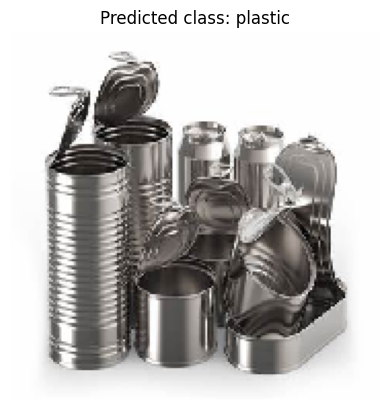

In [ ]:
print('Trash in Image is {} with ACCURACY of {:0.2f}%'.format(data_cat[np.argmax(score)], np.max(score)*100))

plt.figure(dpi=100)
plt.imshow(image)  # Use the loaded image directly
plt.title(f"Predicted class: {data_cat[np.argmax(score)]}")
plt.axis('off')
plt.show()

In [ ]:
import tensorflow_model_optimization as tfmot
print(tfmot.__file__)

/usr/local/lib/python3.10/dist-packages/tensorflow_model_optimization/__init__.py


# **SAVE MODEL**

In [ ]:
model.export('./saved_model')

Saved artifact at './saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name='keras_tensor_1074')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  131949856524064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131949480588944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131949852825504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131949852829904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131949852828848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131949852830608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131949417599696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131949417597408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131949417427920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131949417415424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131949417424

# **pre-quantized**

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model("./saved_model")
tflite_model = converter.convert()

In [ ]:
len(tflite_model)

95009584

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model("./saved_model")
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()

In [ ]:
len(tflite_quant_model)

24179944

# **SAVE H5/KERAS**

In [ ]:
model.save('model.keras')


# RELOAD

In [ ]:
# Reload the model from the .keras file
model_reloaded = tf.keras.models.load_model('model.keras')

# Save the model as an HDF5 file
model_reloaded.save('model.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


# **QUANTIZE**

In [ ]:
# Convert the .h5 model to a TensorFlow Lite model with quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model_reloaded)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

# Save the quantized model
with open('quantized_model.tflite', 'wb') as f:
    f.write(tflite_quantized_model)


Saved artifact at '/tmp/tmpfy7y37l4'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  134631927950224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134631968383648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134631968389984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134631968380832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134631968378016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134631968376608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134631968376080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134631964655856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134631964657088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134631964659904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1346319646657

# **QUANTIZED.H5**

In [ ]:
import tensorflow as tf

# Assuming `model` is your trained Keras model

# Step 1: Clone the original model
quantized_model = tf.keras.models.clone_model(model)
quantized_model.set_weights(model.get_weights())

# Step 2: Manually quantize weights
for layer in quantized_model.layers:
    if hasattr(layer, 'kernel'):
        # Quantize the weights to a lower precision using `tf.quantization.fake_quant_with_min_max_args`
        layer.kernel.assign(
            tf.quantization.fake_quant_with_min_max_args(layer.kernel, min=-6, max=6)
        )

# Step 3: Compile the quantized model (necessary to save and use it)
quantized_model.compile(optimizer='adam',
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])

# Step 4: Save the quantized model as an `.h5` file
quantized_model.save("quantized_model.h5")


# LOAD QUANTIZED

In [ ]:
import tensorflow as tf

# Example: Using the MNIST dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

# Preprocess the data (adjust as needed for your model)
test_images = test_images.reshape(-1, 28, 28, 1).astype("float32") / 255.0


In [ ]:
loaded_model = tf.keras.models.load_model("quantized_model.h5")

# Now you can evaluate or use this loaded model
loss, acc = loaded_model.evaluate(test_images, test_labels, verbose=2)
print("Loaded quantized model accuracy: {:5.2f}%".format(100 * acc))


ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "resnet50" is incompatible with the layer: expected shape=(None, 180, 180, 3), found shape=(None, 28, 28)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 28, 28, 1), dtype=float32)
  • training=False
  • mask=None

In [ ]:
import tensorflow as tf
import tensorflow_model_optimization as tfmot

# Assuming `model` is your original Sequential model
try:
    # Apply quantization directly to the Sequential model
    quantize_model = tfmot.quantization.keras.quantize_apply(model)

    # Recompile the quantized model
    quantize_model.compile(optimizer='adam',
                           loss='sparse_categorical_crossentropy',
                           metrics=['accuracy'])

    # Save the quantized model in the Sequential format as an h5 file
    quantize_model.save('quantized_model_sequential.h5')
    print("Quantized Sequential model saved as 'quantized_model_sequential.h5'.")
except Exception as e:
    print(f"Quantization error: {e}")


Quantization error: `model` can only be a `keras.Model` instance.You passed an instance of type: Sequential.


In [ ]:
print(type(model))


<class 'keras.src.models.sequential.Sequential'>


# **CONVERT SEQUENTIAL TO MODEL**

In [ ]:
from tensorflow.keras import Model, Input

# Wrap the Sequential model with an Input layer
inputs = Input(shape=(img_height, img_width, 3))
outputs = model(inputs)
model = Model(inputs, outputs)


In [ ]:
annotated_model = tf.keras.Sequential([
    tfmot.quantization.keras.quantize_annotate_layer(tf.keras.layers.InputLayer(input_shape=(img_height, img_width, 3))),
    tfmot.quantization.keras.quantize_annotate_layer(tf.keras.layers.Conv2D(32, (3, 3), activation='relu')),
    tfmot.quantization.keras.quantize_annotate_layer(tf.keras.layers.Flatten()),
    tfmot.quantization.keras.quantize_annotate_layer(tf.keras.layers.Dense(10, activation='softmax'))
])


In [ ]:
# Annotate the model for quantization
annotated_model = tfmot.quantization.keras.quantize_annotate_model(model)

# Apply quantization
with tfmot.quantization.keras.quantize_scope():
    quantized_model = tfmot.quantization.keras.quantize_apply(annotated_model)

# Compile the quantized model
quantized_model.compile(optimizer='adam',
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])

# Save the quantized model
quantized_model.save('quantized_model_direct.h5')


ValueError: `to_annotate` can only be a `keras.Model` instance. Use the `quantize_annotate_layer` API to handle individual layers. You passed an instance of type: Sequential.

# **TFJS**

In [ ]:
import tensorflowjs as tfjs

In [ ]:
import tensorflowjs as tfjs

# Path where your 'saved_model' directory is located
saved_model_path = "saved_model"

# Path to save the model in TFJS format
tfjs_target_dir = "tfjs_model"

# Convert the model
tfjs.converters.convert_tf_saved_model(saved_model_path, tfjs_target_dir)


In [ ]:
import json
import pandas as pd

# Convert predictions or DataFrame to JSON
predictions = model.predict(test_data)  # Example prediction step
predictions_json = predictions.to_json(orient='records')  # If predictions are in DataFrame format

# Save to a JSON file
with open("predictions.json", "w") as f:
    f.write(predictions_json)


NameError: name 'test_data' is not defined

In [ ]:
import shutil

# Zip the tfjs_model directory
shutil.make_archive('saved_model', 'zip', 'saved_model') # Changed tfjs_model to 'tfjs_model', representing the folder name

'/content/saved_model.zip'

In [ ]:
model.save('model.keras')

In [ ]:
model.save('model.h5')


In [ ]:
import numpy as np
print(np.__version__)

1.26.4
